<a href="https://colab.research.google.com/github/AlexeyTri/Yolo8-app/blob/main/YOLO8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics==8.0.20

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

import json
import os
import shutil

from tqdm import tqdm
from pprint import pprint
from sklearn.model_selection import train_test_split
import torch
import torchvision
import torchvision.transforms as transforms

In [123]:
from ultralytics import YOLO

from IPython.display import display, Image

Подключаем ЯНДЕКС-диск и загружаем БД с фотографиями

In [ ]:
!wget https://gist.githubusercontent.com/Yegorov/dc61c42aa4e89e139cd8248f59af6b3e/raw/20ac954e202fe6a038c2b4bb476703c02fe0df87/ya.py
!chmod +x ya.py
!./ya.py https://disk.yandex.ru/d/Rx6PNLfOakcttw /content/sample_data/dataset

In [ ]:
!unzip Датасеты.zip -d datasets

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/datasets/Датасеты/Персонал/dataset/annotation_data.json') as annotations_file:
    annotations_js = json.load(annotations_file)
    print('Annotations')
    print(annotations_js.keys())
    
with open('/content/datasets/Датасеты/Персонал/dataset/coco_categories.json') as coco_categories_file:
    coco_categories_js = json.load(coco_categories_file)
    print('Coco categories')
    print(coco_categories_js.keys())
    pprint(coco_categories_js['categories'])

In [ ]:
categories_dict = dict()
for category in annotations_js['categories']:
    categories_dict[category['id']] = category['name']
pprint(categories_dict)

In [65]:
for filename in os.scandir('/content/datasets/Датасеты/Персонал/dataset/images'):
    print(filename, end=" ")

<DirEntry '2020-10-20_3'> <DirEntry '2020-10-28'> <DirEntry '2020-10-20_2'> <DirEntry '2020-10-16'> <DirEntry '2020-10-17'> <DirEntry '2020-10-20_1'> 

In [49]:
images_dict = dict()
for image in annotations_js['images']:
    images_dict[image['id']] = image['file_name']
print(images_dict[1000000])

NIK_2020-10-28/1_3_2020_10_26-06_28_12.701.jpg


In [50]:
annotations_df = []
for annotation in tqdm(annotations_js['annotations']):
    tmp = {
        'image_id': annotation['image_id'],
        'image_path': images_dict[annotation['image_id']],
        'category_id': annotation['category_id'],
        'category_name': categories_dict[annotation['category_id']],
        'bbox': list(map(lambda x: round(x, 2), annotation['bbox'])),
        'area': annotation['area']
    }
    annotations_df.append(tmp)

annotations_df = pd.DataFrame(annotations_df)

100%|██████████| 21275/21275 [00:00<00:00, 195286.92it/s]


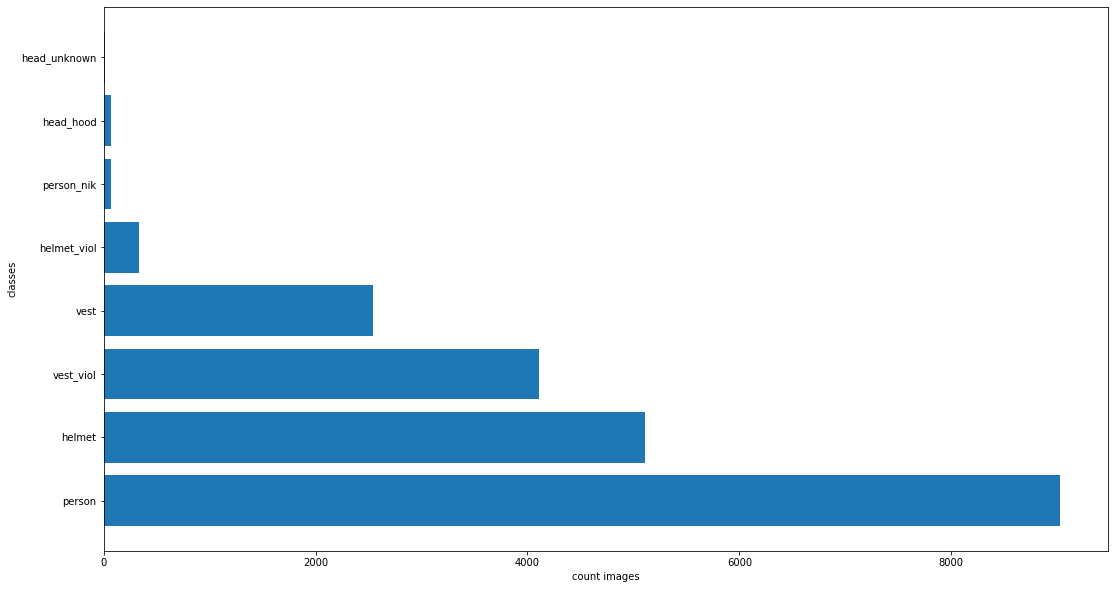

In [52]:
vc = annotations_df['category_name'].value_counts()

plt.figure(figsize=(18,10))
plt.barh(vc.index, vc.values)
plt.ylabel('classes')
plt.xlabel('count images')
plt.show()

In [154]:
def image_description_yolo8(image_data: pd.DataFrame, path: str = '/content/datasets/Датасеты/Персонал/dataset/images') -> np.array:
    image_id = image_data['image_id'].values[0]
    image_path = image_data['image_path'].values[0][4:]
    img = cv2.cvtColor(
        cv2.imread(os.path.join(path, image_path)),
        cv2.COLOR_BGR2RGB
    )
    img_height, img_width, _ = img.shape
    result_description = []
    
    for idx, row in image_data.iterrows():
        category_id = row['category_id']
        bbox = row['bbox']
        x1, y1, obj_width, obj_height = tuple(bbox)
        x_center = x1 + (obj_width / 2)
        y_center = y1 + (obj_height / 2)
        x_center /= img_width
        obj_width /= img_width
        y_center /= img_height
        obj_height /= img_height
        desc = {
            'category_id': category_id,
            'x_center': x_center,
            'y_center': y_center,
            'bbox_width': obj_width,
            'bbox_height': obj_height
        }
        result_description.append(desc)
        
    return pd.DataFrame(result_description)


def prepare_folders():
    if not os.path.exists('yolo_model_dataset'):
        os.makedirs('yolo_model_dataset')
    
    os.makedirs('./yolo_model_dataset/train/images')
    os.makedirs('./yolo_model_dataset/train/labels')
    
    os.makedirs('./yolo_model_dataset/val/images')
    os.makedirs('./yolo_model_dataset/val/labels')
    
    
def split_images(annotations_df: pd.DataFrame, test_size: float = 0.2, random_state = 5) -> pd.DataFrame:
    images_to_split = annotations_df['image_id'].unique()

    images_train, images_val = train_test_split(images_to_split, test_size=test_size, random_state=5)

    train_images = pd.Series(index=images_train, data=1)
    val_images = pd.Series(index=images_val, data=0)

    images_splitted = pd.concat([train_images, val_images])

    annotations_df['is_train'] = annotations_df['image_id'].map(images_splitted)
    return annotations_df

    
def copy_images(annotations_df: pd.DataFrame, test_size: float = 0.2, images_path: str = '/content/datasets/Датасеты/Персонал/dataset/images'):
    
    if 'is_train' not in annotations_df.columns:
        annotations_df = split_images(annotations_df)
    
    for image_id in tqdm(annotations_df['image_id'].unique()):
        cur_image_data = annotations_df.loc[
            annotations_df['image_id'] == image_id
        ]
        image_path = cur_image_data['image_path'].values[0][4:]
        is_train = image_id['is_train'].values[0]
        
        image_description = image_description_yolo8(cur_image_data, images_path)
        image_name = os.path.basename(image_path)
        
        if is_train:
            shutil.copy(
                os.path.join(images_path, image_path),
                os.path.join('./yolo_model_dataset/train/images', image_name)
            )
            image_description.to_csv(
                os.path.join('./yolo_model_dataset/train/labels', image_name + '.txt'),
                index=False,
                header=False,
                sep=' '
            )
            
        else:
            shutil.copy(
                os.path.join(images_path, image_path),
                os.path.join('./yolo_model_dataset/val/images', image_name)
            )
            image_description.to_csv(
                os.path.join('./yolo_model_dataset/val/labels', image_name + '.txt'),
                index=False,
                header=False,
                sep=' '
            )

In [153]:
annotations_df[annotations_df['image_id'] == 1001854]['is_train']

0    1
1    1
2    1
3    1
4    1
5    1
6    1
7    1
Name: is_train, dtype: int64

In [152]:
annotations_df['is_train'].values[0]

1

In [ ]:
1001854

In [121]:
prepare_folders()
copy_images(annotations_df)

100%|██████████| 2392/2392 [02:19<00:00, 17.15it/s]


ВЫШЕ РАБОТАЮЩИЙ КОД


In [128]:
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='/content/datasets/Датасеты/Персонал/dataset/images/2020-10-17/_15_004325.jpg' save='/content/my/detect/predict/'

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs
image 1/1 /content/datasets/Датасеты/Персонал/dataset/images/2020-10-17/_15_004325.jpg: 384x640 1 boat, 14.8ms
Speed: 0.5ms pre-process, 14.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict2


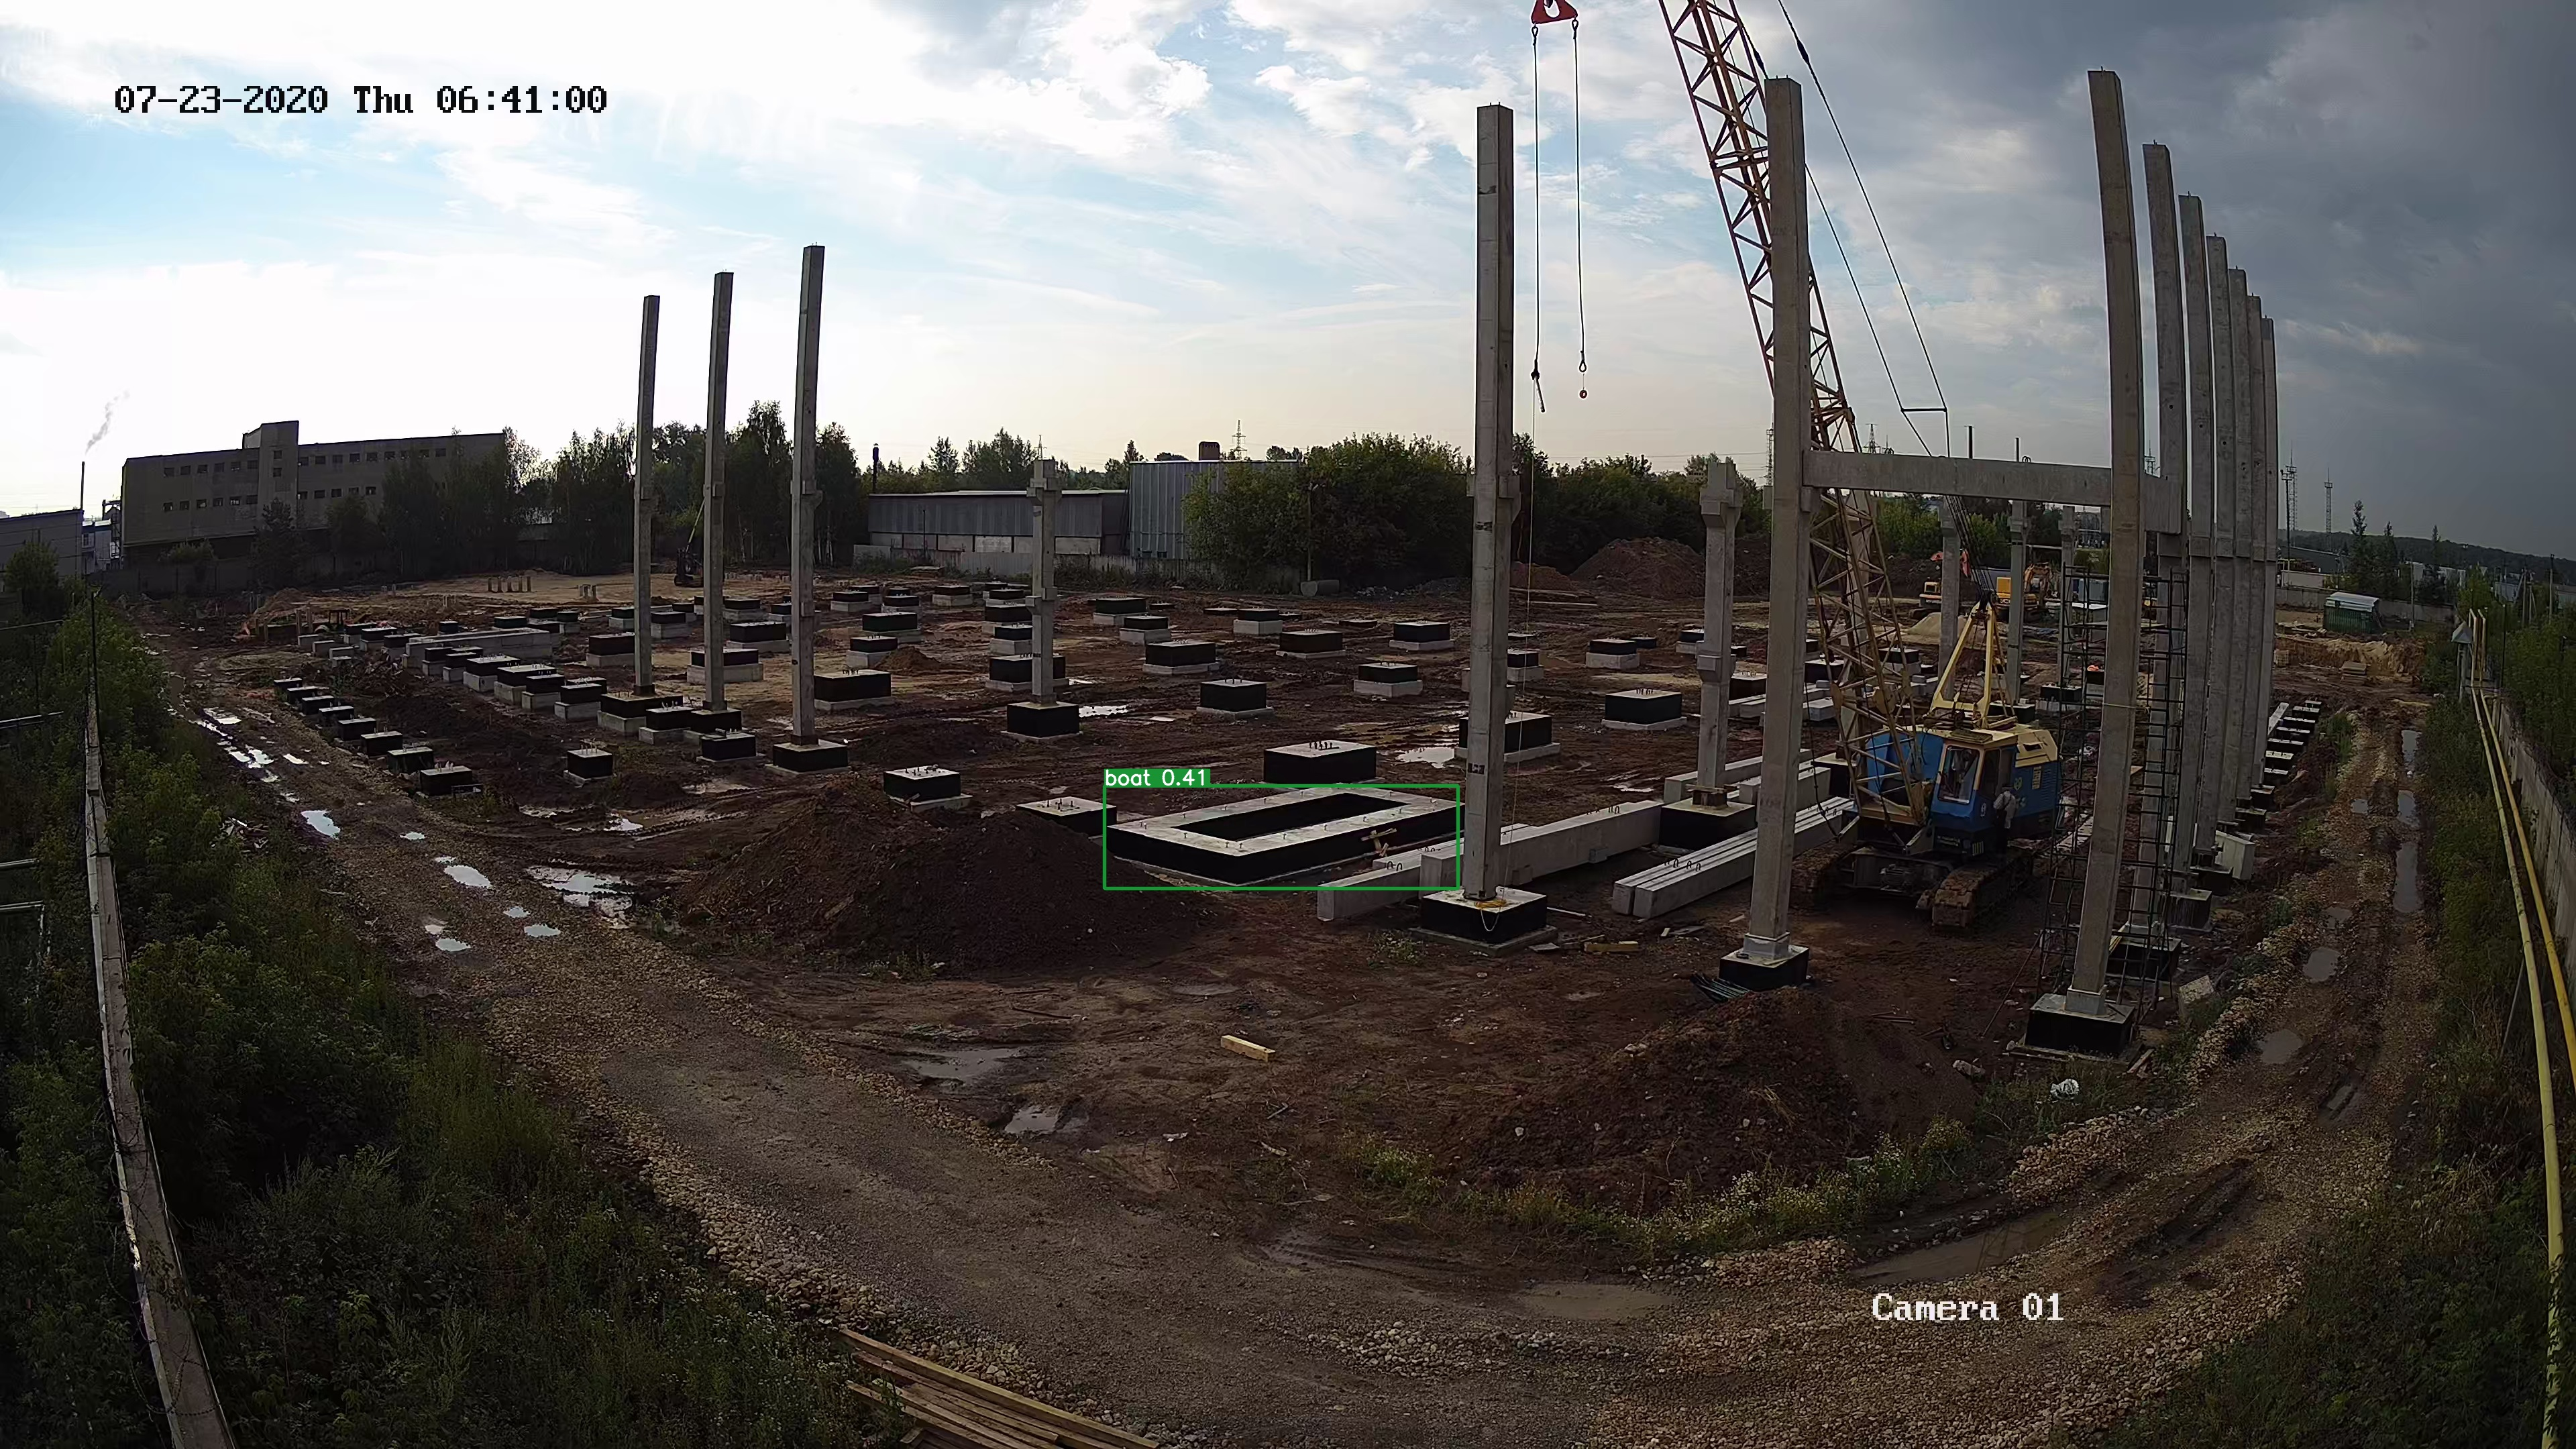

In [129]:
Image(filename='/content/runs/detect/predict2/_15_004325.jpg', height=600)

добавим дашборд

In [136]:
import torch
import torchvision
import torchvision.transforms as transforms

In [130]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/construction_detection')

In [131]:
model = YOLO('yolov8n.pt')

In [142]:
import yaml

custom = {'path':  '/content/yolov8n.pt',
           'train': '/content/yolo_model_dataset/train',
           'val': '/content/yolo_model_dataset/val',
            'names': {3: 'person',
 4: 'vest',
 5: 'vest_viol',
 6: 'helmet',
 7: 'helmet_viol',
 8: 'welding_mask',
 9: 'head_hood',
 10: 'person_nik',
 11: 'head_unknown'}
         }

# Convert Python dictionary into a YAML document
with open(r'custom.yaml', 'w') as file:
    documents = yaml.dump(custom, file)

In [ ]:
# Use the model
results = model.train(data='custom.yaml', epochs=5, device="0")  # train the model
success = model.export(format='onnx')  # export the model to ONNX format

НИЖЕ КОД ДЛЯ ОБУЧЕНИЯ МОДЕЛИ

In [ ]:
!pip3 install torch torchvision torchaudio
!pip3 install split-folders

проверим, что GPU включен

In [1]:
!nvidia-smi

Sun Feb 26 09:56:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P0    30W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


Установка YOLO8

In [3]:
!pip install ultralytics==8.0.20

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 25.8/78.2 GB disk)


In [4]:
from ultralytics import YOLO

from IPython.display import display, Image

In [7]:
!pip3 install torch torchvision torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import torch
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

In [10]:
%cd {HOME}
!yolo task=detect mode=predict model=yolov8n.pt conf=0.25 source='https://media.roboflow.com/notebooks/examples/dog.jpeg' save=True

/content
100% 6.23M/6.23M [00:00<00:00, 320MB/s]

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs
100% 104k/104k [00:00<00:00, 7.55MB/s]
image 1/1 /content/dog.jpeg: 640x384 1 person, 1 car, 1 dog, 15.6ms
Speed: 0.6ms pre-process, 15.6ms inference, 40.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


/content


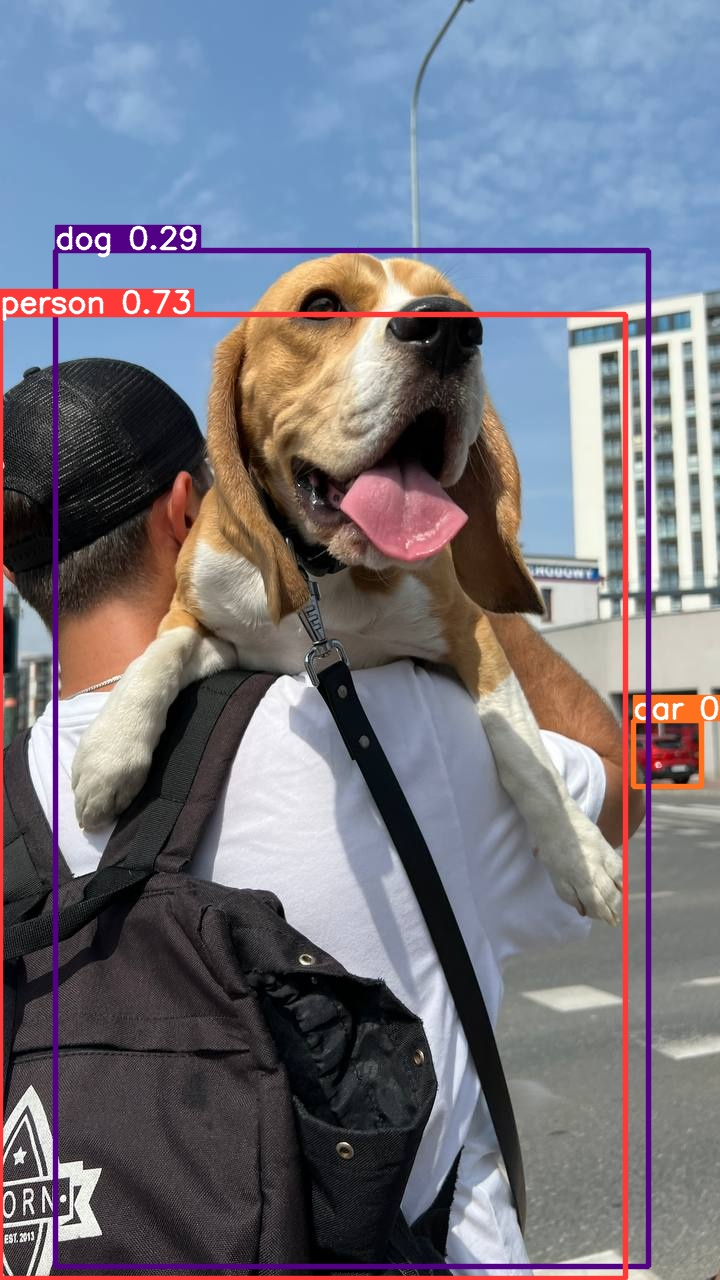

In [11]:
%cd {HOME}
Image(filename='runs/detect/predict/dog.jpeg', height=600)

In [18]:
model = YOLO(f'{HOME}/yolov8n.pt')
results = model.predict(source='https://media.roboflow.com/notebooks/examples/dog.jpeg', conf=0.25)

Ultralytics YOLOv8.0.20 🚀 Python-3.8.10 torch-1.13.1+cu116 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs
Found https://media.roboflow.com/notebooks/examples/dog.jpeg locally at dog.jpeg


In [19]:
results[0].boxes.xyxy

tensor([[   0.,  314.,  625., 1278.],
        [  55.,  250.,  648., 1266.],
        [ 633.,  720.,  701.,  786.]], device='cuda:0')

In [ ]:
model.add_callback()

In [12]:
from pathlib import Path
from tqdm import tqdm
import numpy as np
import json
import urllib
import PIL.Image as Image
import cv2
import torch
import torchvision
from IPython.display import display
from sklearn.model_selection import train_test_split

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import os
import json
from pprint import pprint
import shutil
import splitfolders

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
rcParams['figure.figsize'] = 16, 10

np.random.seed(42)

In [13]:
clases = ['Погрузчик',
 'Самосвал',
 'Экскаватор',
 'Кран_автомобильный',
 'Легковой_автомобиль',
 'Грузовой_не_спец_транспорт',
 'Сваебойная_установка_гусеничная',
 'Экскаватор-погрузчик',
 'Бульдозер',
 'Автобетоносмеситель',
 'Манипулятор',
 'Выключатель',
 'Силовой_трансформатор',
 'Автогидроподъемник']

In [16]:
img = cv2.cvtColor(cv2.imread('/content/datasets/Датасеты/Персонал/dataset/images/2020-10-16/_8/_8_000350.jpg'), cv2.COLOR_BGR2RGB)
img.shape

(2160, 3840, 3)

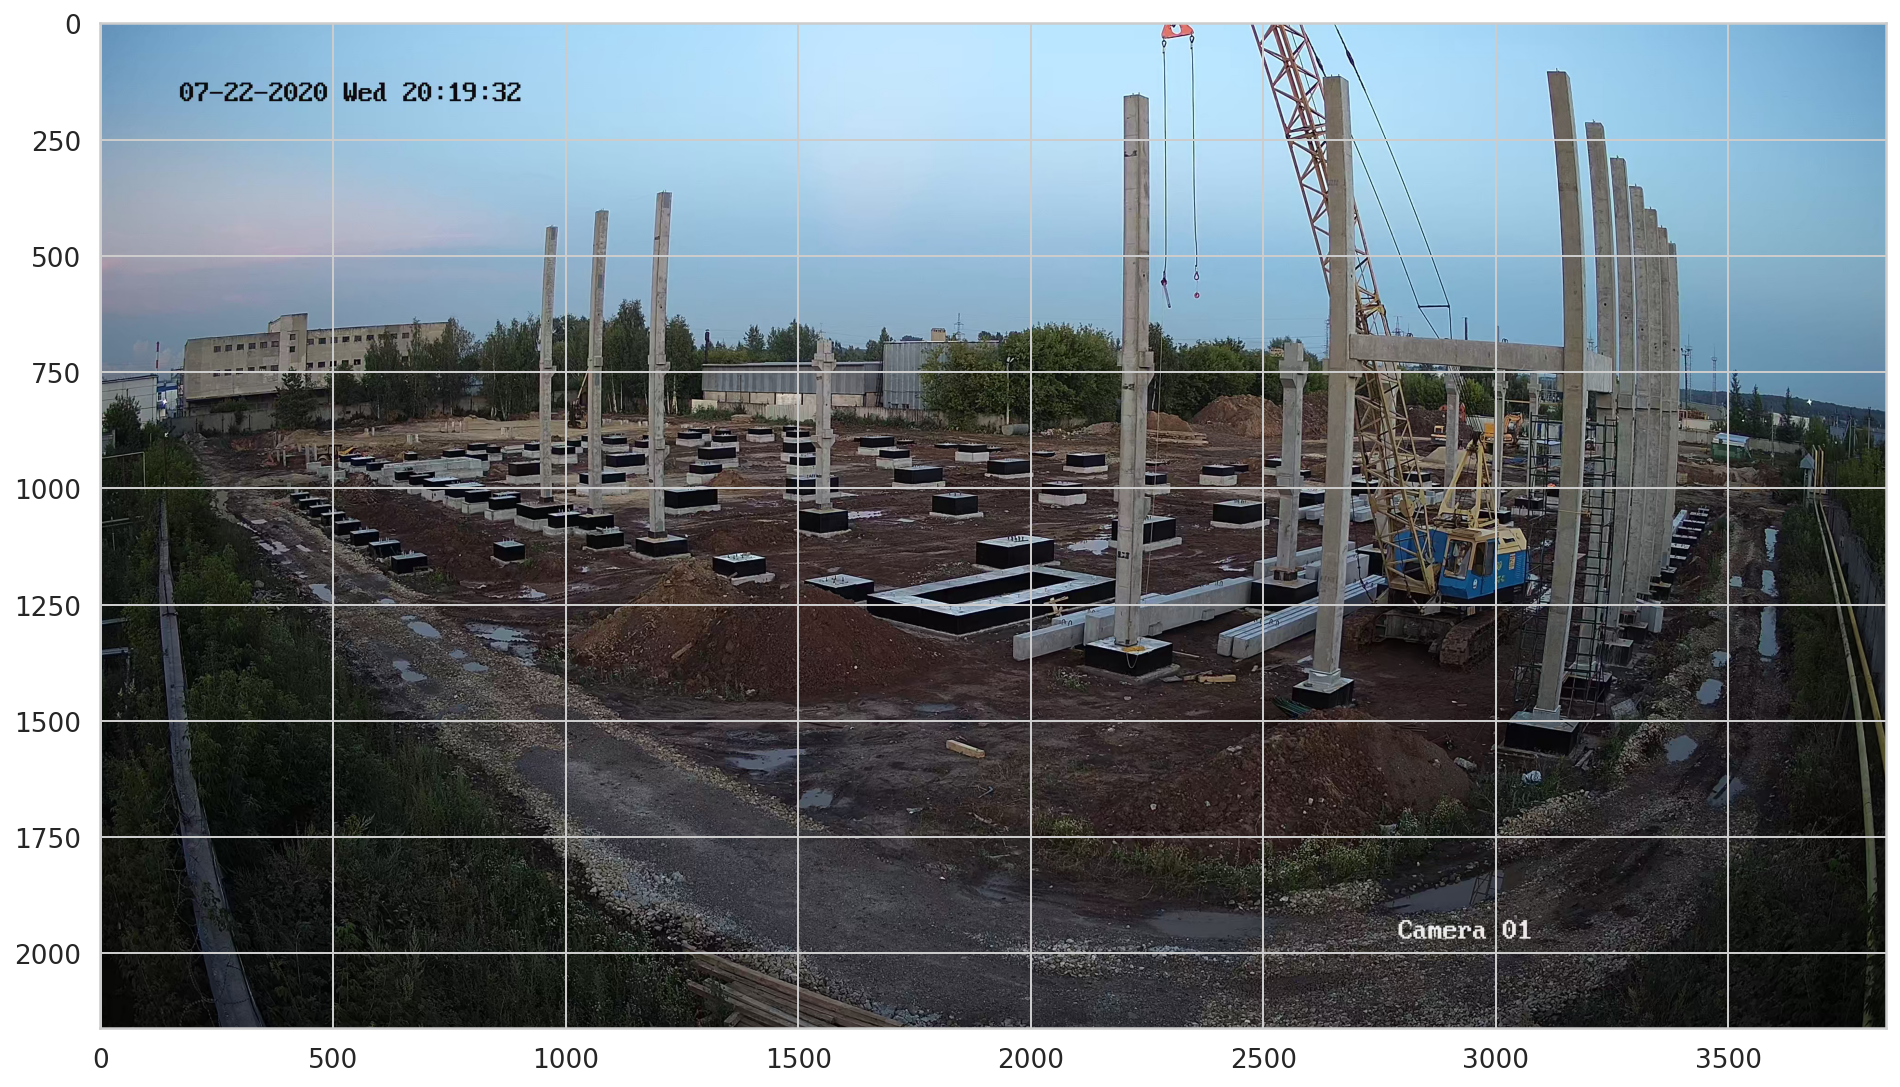

In [20]:
plt.imshow(img)

In [19]:
img = np.asarray(Image.open('/content/datasets/Датасеты/Персонал/dataset/images/2020-10-16/_8/_8_000350.jpg'))